# Inception using PyTorch Lightning

# description

### Imports

In [5]:
import os

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from IPython.display import Image
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
pl.seed_everything(42)

Seed set to 42


42

### Folders for datasets and saved models

In [6]:
DATASET_PATH = '../data'
CHECKPOINT_PATH = '../checkpoints'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### Means and stdevs for normalization

In [7]:
train_data = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_data.data / 255.0).mean(axis=(0,1,2))
DATA_STDS = (train_data.data / 255.0).std(axis=(0,1,2))
print("Means", DATA_MEANS)
print("Stdevs", DATA_STDS)

Files already downloaded and verified
Means [0.49139968 0.48215841 0.44653091]
Stdevs [0.24703223 0.24348513 0.26158784]


### Datasets and dataloaders

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8,1.0), ratio=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STDS) 
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STDS) 
])

train_dataset = CIFAR10(DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(DATASET_PATH, train=True, transform=test_transform, download=True)

train_ds, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_ds = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_ds = CIFAR10(DATASET_PATH, train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Check normalization

In [9]:
first_batch, _ = next(iter(train_loader))
print("mean", first_batch.mean(dim=(0, 2, 3)))
print("std", first_batch.std(dim=(0, 2, 3)))

mean tensor([0.0570, 0.0447, 0.0552])
std tensor([0.9263, 0.9464, 0.9932])


### Inception block

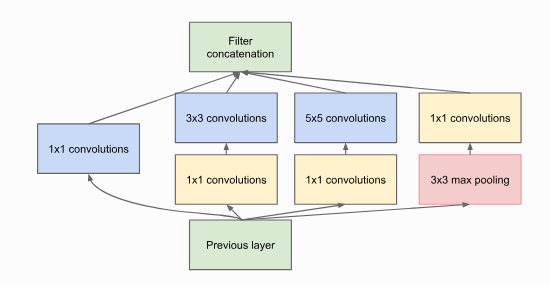

In [10]:
Image('../images/inception-block.png')

Additionally, there is a batchnorm and ReLU activation after every convolution.

In [11]:
class InceptionBlock(nn.Module):
    """
    Inputs:
        - in_channels: number of input channels
        - reduction_dict: dictionary with keys "3x3" and "5x5"
            specifying the number of output channels for the 1x1
            convolutions before the 3x3 and 5x5 convolutions
        - out_dict: dictionary with keys "1x1", "3x3", "5x5", and "pool"
            specifying the number of output channels for the 1x1, 3x3, 5x5
            convolutions and the pooling layer
    """
    def __init__(self, in_channels, reduction_dict, out_dict):
        super().__init__()

        # 1x1 conv branch
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_dict["1x1"], kernel_size=1),
            nn.BatchNorm2d(out_dict["1x1"]),
            nn.ReLU()
        )

        # 3x3 conv branch
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels, reduction_dict["3x3"], kernel_size=1),
            nn.BatchNorm2d(reduction_dict["3x3"]),
            nn.ReLU(),
            nn.Conv2d(reduction_dict["3x3"], out_dict["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dict["3x3"]),
            nn.ReLU()
        )

        # 5x5 conv branch
        self.conv5x5 = nn.Sequential(
            nn.Conv2d(in_channels, reduction_dict["5x5"], kernel_size=1),
            nn.BatchNorm2d(reduction_dict["5x5"]),
            nn.ReLU(),
            nn.Conv2d(reduction_dict["5x5"], out_dict["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(out_dict["5x5"]),
            nn.ReLU()
        )

        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_dict["pool"], kernel_size=1),
            nn.BatchNorm2d(out_dict["pool"]),
            nn.ReLU()
        )
    
    def forward(self, x):
        out1x1 = self.conv1x1(x)
        out3x3 = self.conv3x3(x)
        out5x5 = self.conv5x5(x)
        out_pool = self.max_pool(x)
        return torch.cat([out1x1, out3x3, out5x5, out_pool], dim=1)

### Simplified GoogLeNet model

In [27]:
class SimpleGoogle(nn.Module):
    def __init__(self):
        super().__init__()
        self._create_network()
        self._initialize_weights()

    def _create_network(self):
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64,
                reduction_dict={"3x3": 32, "5x5": 16},
                out_dict={"1x1": 24, "3x3": 48, "5x5": 12, "pool": 12}
            ),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96,
                reduction_dict={"3x3": 32, "5x5": 16},
                out_dict={"1x1": 32, "3x3": 48, "5x5": 24, "pool": 24}
            ),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128,
                reduction_dict={"3x3": 48, "5x5": 16},
                out_dict={"1x1": 32, "3x3": 64, "5x5": 16, "pool": 16}
            )
        )
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

### Lightning module

In [28]:
class CIFARModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SimpleGoogle()
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = self.loss_fn(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs).argmax(dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs).argmax(dim=1)
        acc = (preds == labels).float().mean()
        self.log('test_acc', acc)

### Function to train and evaluate model

In [29]:
def train_model(max_epochs=10):

    trainer = Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimpleGoogle'),
        accelerator='cpu',
        max_epochs=max_epochs,
        callbacks=[ModelCheckpoint(save_weights_only=True, monitor='val_acc', mode='max')],
        enable_progress_bar=True,
        limit_train_batches=0.1,
        limit_val_batches=0.2,
        limit_test_batches=0.3
    )
    trainer.logger._default_hp_metric = None
    trainer.logger._log_graph = True

    model = CIFARModule()
    trainer.fit(model, train_loader, val_loader)
    model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [30]:
train_model(max_epochs=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | SimpleGoogle     | 110 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.442     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 35/35 [00:41<00:00,  0.84it/s, v_num=5]          

`Trainer.fit` stopped: `max_epochs=4` reached.


Testing DataLoader 0: 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]


(CIFARModule(
   (model): SimpleGoogle(
     (input_net): Sequential(
       (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (inception_blocks): Sequential(
       (0): InceptionBlock(
         (conv1x1): Sequential(
           (0): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1))
           (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU()
         )
         (conv3x3): Sequential(
           (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU()
           (3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (5): ReLU()
         )
         (con

In [32]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
%tensorboard --logdir ../checkpoints/SimpleGoogle

Reusing TensorBoard on port 6006 (pid 2656), started 0:26:57 ago. (Use '!kill 2656' to kill it.)